In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.contrib import rnn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
def inference(x, n_in=None, n_time=None, n_hidden=None, n_out=None):
    def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=0.01)
        return tf.Variable(initial)
    
    def bias_variable(shape):
        initial = tf.zeros(shape, dtype=tf.float32)
        return tf.Variable(initial)
    
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_in])
    x = tf.split(x, n_time, 0)
    
    cell_forward = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    cell_backward = rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    
    outputs, _, _ = rnn.static_bidirectional_rnn(cell_forward, cell_backward, 
                                                x, dtype=tf.float32)
    
    W = weight_variable([n_hidden * 2, n_out])
    b = bias_variable([n_out])
    y = tf.nn.softmax(tf.matmul(outputs[-1], W) + b)
    
    return y

In [3]:
def loss(y, t):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(t * tf.log(
        tf.clip_by_value(y, 1e-10, 1.0)), reduction_indices=[1]))
    return cross_entropy

In [4]:
def training(loss):
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999)
    train_step = optimizer.minimize(loss)
    return train_step

In [5]:
def accuracy(y, t):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

In [6]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose
        
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss
        return False

In [7]:
mnist = datasets.fetch_mldata('MNIST original', data_home='.')

In [8]:
n = len(mnist.data)
N = 30000
N_train = 20000
N_validation = 4000
indices = np.random.permutation(range(n))[:N]

In [9]:
X = mnist.data[indices]
X = X / 255.0
X = X - X.mean(axis=1).reshape(len(X), 1)
X = X.reshape(len(X), 28, 28)
y = mnist.target[indices]
Y = np.eye(10)[y.astype(int)]

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=N_train)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=N_validation)

# Tensorflowによる実装

In [11]:
n_in = 28
n_time = 28
n_hidden = 128
n_out = 10

x = tf.placeholder(tf.float32, shape=[None, n_time, n_in])
t = tf.placeholder(tf.float32, shape=[None, n_out])

y = inference(x, n_in=n_in, n_time=n_time, n_hidden=n_hidden, n_out=n_out)
loss = loss(y, t)
train_step = training(loss)
accuracy = accuracy(y, t)

early_stopping = EarlyStopping(patience=10, verbose=1)
history = {
    'val_loss': [],
    'val_acc': []
}

In [12]:
epochs = 30
batch_size = 250

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

n_batches = N_train // batch_size

In [13]:
for epoch in range(epochs):
    X_, Y_ = shuffle(X_train, Y_train)
    
    for i in range(n_batches):
        start = i * batch_size
        end = start + batch_size
        
        sess.run(train_step, feed_dict={
            x: X_[start:end],
            t: Y_[start:end]
        })
        
    val_loss = loss.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation
    })
    val_acc = accuracy.eval(session=sess, feed_dict={
        x: X_validation,
        t: Y_validation
    })
    
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print('epoch:', epoch,
         ' validation loss:', val_loss,
         ' validation accuracy:', val_acc)
    
    if early_stopping.validate(val_loss):
        break

epoch: 0  validation loss: 1.60626  validation accuracy: 0.41825
epoch: 1  validation loss: 1.2503  validation accuracy: 0.60425
epoch: 2  validation loss: 0.749565  validation accuracy: 0.76025
epoch: 3  validation loss: 1.03549  validation accuracy: 0.681
epoch: 4  validation loss: 0.823993  validation accuracy: 0.74525
epoch: 5  validation loss: 0.295799  validation accuracy: 0.9085
epoch: 6  validation loss: 0.482697  validation accuracy: 0.8535
epoch: 7  validation loss: 0.316508  validation accuracy: 0.897
epoch: 8  validation loss: 0.233702  validation accuracy: 0.92975
epoch: 9  validation loss: 0.228454  validation accuracy: 0.93
epoch: 10  validation loss: 0.460603  validation accuracy: 0.8575
epoch: 11  validation loss: 0.236781  validation accuracy: 0.92875
epoch: 12  validation loss: 0.293696  validation accuracy: 0.90925
epoch: 13  validation loss: 0.503939  validation accuracy: 0.849
epoch: 14  validation loss: 0.188899  validation accuracy: 0.94475
epoch: 15  validation

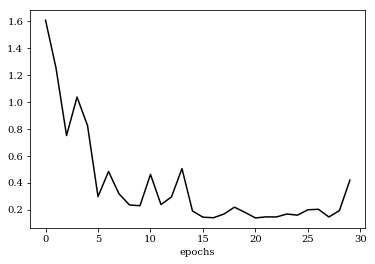

accuracy:  0.8895


In [14]:
loss = history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(loss)), loss,
             label='loss', color='black')
plt.xlabel('epochs')
plt.show()

accuracy_rate = accuracy.eval(session=sess, feed_dict={
        x: X_test,
        t: Y_test
    })
print('accuracy: ', accuracy_rate)

# Kerasによる実装

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [16]:
def weight_variable(shape, name=None):
    return np.random.normal(scale=.01, size=shape)

In [17]:
model = Sequential()
model.add(Bidirectional(LSTM(n_hidden),
                       input_shape=(n_time, n_in)))
model.add(Dense(n_out, init=weight_variable))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
             metrics=['accuracy'])

In [18]:
epochs = 30
batch_size = 250
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

hist = model.fit(X_train, Y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_validation, Y_validation),
                 callbacks=[early_stopping])

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 12s 728us/step - loss: 1.5974 - acc: 0.4492 - val_loss: 0.8789 - val_acc: 0.6910
Epoch 2/30
16000/16000 [==============================] - 11s 702us/step - loss: 0.6351 - acc: 0.7889 - val_loss: 0.4578 - val_acc: 0.8685
Epoch 3/30
16000/16000 [==============================] - 11s 685us/step - loss: 0.3601 - acc: 0.8903 - val_loss: 0.3004 - val_acc: 0.9123
Epoch 4/30
16000/16000 [==============================] - 11s 704us/step - loss: 0.2338 - acc: 0.9285 - val_loss: 0.2479 - val_acc: 0.9255
Epoch 5/30
16000/16000 [==============================] - 11s 684us/step - loss: 0.1898 - acc: 0.9430 - val_loss: 0.1963 - val_acc: 0.9415
Epoch 6/30
16000/16000 [==============================] - 11s 687us/step - loss: 0.1560 - acc: 0.9542 - val_loss: 0.1698 - val_acc: 0.9500
Epoch 7/30
16000/16000 [==============================] - 11s 689us/step - loss: 0.1217 - acc: 0.9635 - val_loss: 0.1

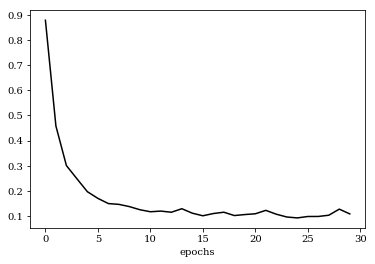

In [19]:
acc = hist.history['val_acc']
loss = hist.history['val_loss']

plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(len(loss)), loss,
         label='loss', color='black')
plt.xlabel('epochs')
plt.show()

In [20]:
loss_and_metrics = model.evaluate(X_test, Y_test)
print(loss_and_metrics)

10000/10000 [==============================] - 2s 250us/step
[0.10811537804752588, 0.97130000000000005]
